In [6]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from GaussianOptics import ThinLens,Gaussian_propagation2d,DrawBeamCountour
c=299792458*1000

### Measuring the optimal points of the Rx horn for the CHAMP optics. 

The CHAMP optics was designed to converge the Rx feedhorn and match it to the rest optics including telescope optics and the designed Gaden gate optics. 
In order to get the optimal matching and correction illumination edge tape of the telescope, the beamwasit of the receiver horn must be sat at the correction plane. 

Unfortunately, we don't know the exact position of the Gibson horn BW that is used by CHAI receiver. But we can find the beamwaist position by measuring the beam size of the optics and horn. 

In [7]:
#  Information about the CHAMP optics designed for CHAI receiver
#  Here the simulated design is the scale optics operating @ 158.33GHz
'''CHAMP informations'''
freq=158.333*10**9
Lambda1=c/freq
win2=2.74925
din2=26.0865#31.0865#
f2=70.2857
P2=ThinLens(win2, din2, f2, Lambda1)
Ls=30.463
din1=Ls-P2['dout']
f1=74.0689
P1=ThinLens(P2['wout'], din1, f1, Lambda1)

print(P1['wout']-10)
print(P1['dout']-15)
print(P1['Rin'])

-0.0008964341004329412
-0.00033151998587221954
77.15862910053798


**1. draw the Gaussian optics of the two-mirror system**

602 301


(-6.892978083430183,
 144.75253975203384,
 -11.043883982268058,
 11.043883982268058)

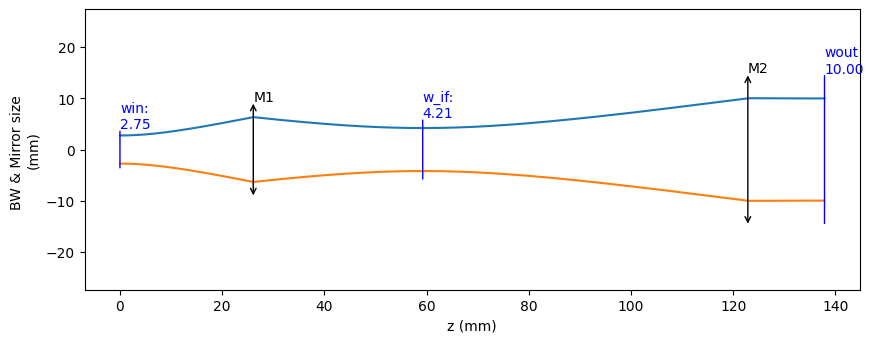

In [8]:

M2=ThinLens(win2, din2, f2, Lambda1)
M1=ThinLens(M2['wout'], din1, f1, Lambda1)
z2,profile2_in,profile2_out=DrawBeamCountour(M2,Nin=301,Nout=301,size=2.5,color='b',offset=0)
z1,profile1_in,profile1_out=DrawBeamCountour(M1,Nin=301,Nout=301,size=2.5,color='b',offset=z2.max())
print(z2.size,profile2_in.size)
z=np.concatenate((z2,z1))
profile=np.concatenate((profile2_in,profile2_out,profile1_in,profile1_out))
fig=plt.figure(figsize=(10,10*5*M1['w_mirror']/(z.max()-z.min())))

plt.plot(z,profile)
plt.plot(z,-profile)
head_width=1
head_length=1.5
linewidth=1

color='b'
plt.text(0,M2['win']*1.5,'win:\n'+"{:.2f}".format(M2['win']),color='blue')
plt.annotate('', xy=(0,M2['win']*1.5), xytext=(0,-M2['win']*1.5), arrowprops=dict(arrowstyle='-',color=color))
#plt.text(M2['din']/2-2,-15,'din:\n'+str(M2['din']))
d1=np.array([M2['din'],M2['dout']])
plt.annotate('', xy=(np.abs(d1).sum(),M2['wout']*1.5), xytext=(np.abs(d1).sum(),-M2['wout']*1.5), arrowprops=dict(arrowstyle='-',color=color))
plt.text(np.abs(d1).sum(),M2['wout']*1.5,'w_if:\n'+"{:.2f}".format(M2['wout']),color='blue')
d2=np.append(d1,np.array([M1['din'],M1['dout']]))
plt.annotate('', xy=(np.abs(d2).sum(),M1['wout']*1.5), xytext=(np.abs(d2).sum(),-M1['wout']*1.5), arrowprops=dict(arrowstyle='-',color=color))
plt.text(np.abs(d2).sum(),M1['wout']*1.5,'wout\n'+"{:.2f}".format(M1['wout']),color='blue')

color='k'
plt.annotate('', xy=(M2['din'],M2['w_mirror']*1.5), xytext=(M2['din'],-M2['w_mirror']*1.5), arrowprops=dict(arrowstyle='<->'),color=color)
plt.text(M2['din'],M2['w_mirror']*1.5,'M1',)
P_m1=np.array([M2['din'],M2['dout'],M1['din']])
P_m1=np.abs(P_m1).sum()
plt.annotate('', xy=(P_m1,M1['w_mirror']*1.5), xytext=(P_m1,-M1['w_mirror']*1.5), arrowprops=dict(arrowstyle='<->'),color=color)
plt.text(P_m1,M1['w_mirror']*1.5,'M2',)
plt.xlabel('z (mm)',fontsize=10)
plt.ylabel('BW & Mirror size \n(mm)',fontsize=10)
plt.axis('equal')

**2.  Simulations of the Lab test**

In the measurment setup, We meausre the peak power of the optical beam by separately placing the detector at 1.0, 1.5 and 2.4 meters away from the CHAMP optics. In different measuring points, the optimal separations between Rx and the CHAMP optics, which can farthest converge the Rx beam, are different. 

Here, we simulate the measured power for the cases with detector mounted at 0.5, 1.0, 1.5, 2.5, and 10 meters away from Rx horn.

In [9]:
def p_w(win,din,dz,s):
    D=np.array([])
    W_out=np.array([])
    W=np.array([])
    P=np.array([])
    """
    Fucntion used to calculate the beam waist at the detector plane for difference movement of the Rx horn.
    """
    for dzz in dz:
        # mirror 2 parameters, input distance is din2+dz, the the output beamwaist and dout are computed.
        p2=ThinLens(win, 18+3.107+dzz, f2, Lambda1)
        # calculate the output beam of mirror1.
        p1=ThinLens(p2['wout'], Ls-p2['dout'], f1, Lambda1)
        # compute the beam width in the detector point based on Gaussian beam propagation.
        z_c, w_z, Rin, q1, phi1, beam = Gaussian_propagation2d(p1['wout'],s-p1['dout']-dzz-din2,Lambda1)
        #print('S:',s-p1['dout']). 
        # Power measured by detector is propotional to the squre of beam waist.
        power=1/w_z**2
        #print(p2['din'])
        W=np.append(W,w_z)
        P=np.append(P,power)
        W_out=np.append(W_out,p1['wout'])
        #D=np.append(D,s-dzz-p1['dout'])
        D=np.append(D,p1['dout'])
    P=P/P.max()
    return D, W_out, W, P

In [10]:
def fn_para(x,a,b,c):
    #return a*x**4 + b*x**3 + c*x**2 + d*x +e 
    return a*(x-b)**2 + c 

def fn_para2(x,a,l,phi,c):
    return a*np.sin(2*np.pi/l*x+phi)+c

[-0.22265224 26.73291241  2.73935756  0.77695415]
err: 0.0003252351195429677 x0: -4.971848460511043
[-4.50268061e-03  8.52586521e+00  9.91529101e-01]
err: 0.02395379000089437
Detector distance 0.93m [8.388]
0.0015703472002113195 0.001573556471892501 

[-0.21206705 25.96547442  2.92093743  0.78766836]
err: 0.00020824750585746868 x0: -5.579503494513456
[-5.02231977e-03  7.36884421e+00  9.94098297e-01]
err: 0.01900276699426129
Detector distance 1.47m [7.3968]
0.0015757484904966867 0.0015805921014893087 

[-0.20762652 25.65443143  2.99832548  0.79213641]
err: 0.00018542967656256588 x0: -5.828643739168884
[-5.16325049e-03  6.95408887e+00  9.95180670e-01]
err: 0.016305946700002072
Detector distance 1.95m [6.9912]
0.001582920060258397 0.00157681490782291 

[-0.20421451 25.41290263  3.0474128   0.79557375]
err: 0.0001682254956534976 x0: -5.972306861382726
[-5.23047845e-03  6.69424826e+00  9.95745202e-01]
err: 0.014362521982632326
Detector distance 2.49m [6.7272]
0.0015833616988357724 0.0015780

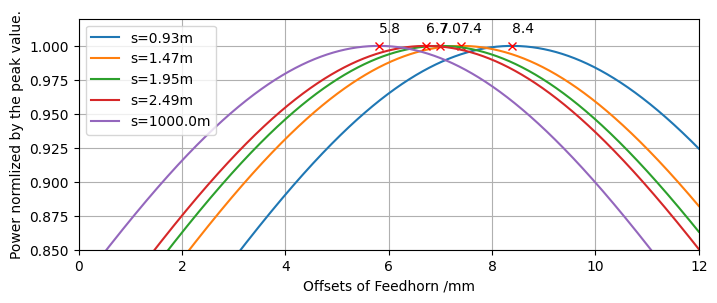

In [11]:
D_source=[930,1470,1950,2490,1000000]
#D_source=[1600]
N_points=5001
z=np.linspace(0,12,N_points)
DeltaZ=(z.max()-z.min())/(N_points-1)
fig=plt.figure(figsize=(8,3))
'''Beam power in detector'''
for item in D_source:
    D_z,W_z,Ws_z,Ps=p_w(win2,din2,z,item)
    '''Beam power in detector'''
    plt.plot(z,Ps,'-',label='s='+str(item/1000)+'m')

    popt, pcov = curve_fit(fn_para2, z, Ps,np.array([1,20,np.pi/2,0.8]))
    print(popt)
    print('err:',np.abs(fn_para2(z,*popt)-Ps).mean(),'x0:',(np.pi/2-(popt[2]%np.pi))*popt[1]/2/np.pi)
    #plt.plot(z,fn_para2(z,*popt),'k--',label='Sine')
    
    popt, pcov = curve_fit(fn_para, z, Ps)
    print(popt)
    print('err:',np.abs(fn_para(z,*popt)-Ps).max())
    #plt.plot(z,fn_para(z,*popt),'b--',label='Parabolic')
    
    NN=np.where(Ps==1.0)
    dN=int(0.5/DeltaZ)
    print('Detector distance '+str(item/1000)+'m',z[NN])
    print(1-Ps[NN[0][0]-dN],1-Ps[NN[0][0]+dN],'\n')
    peaks, _ = find_peaks(Ps, height=0)
    plt.text(z[peaks]*1,Ps[peaks]*1.01, "{:.1f}".format(z[peaks][0]),fontsize=10)
    plt.plot(z[peaks], Ps[peaks], "rx")
    #plt.plot(z[NN],1.0,'r*')
#plt.ylim([0.8,1.05])
plt.ylim([0.85,1.02])
plt.xlim([z.min(),z.max()])
plt.legend()
plt.xlabel('Offsets of Feedhorn /mm')
plt.ylabel('Power normlized by the peak value.')
plt.grid('both')
plt.show()

[-20.58122175 -20.55700866 -20.53278729 ... 102.10265339 102.11169128
 102.12072209] 5001


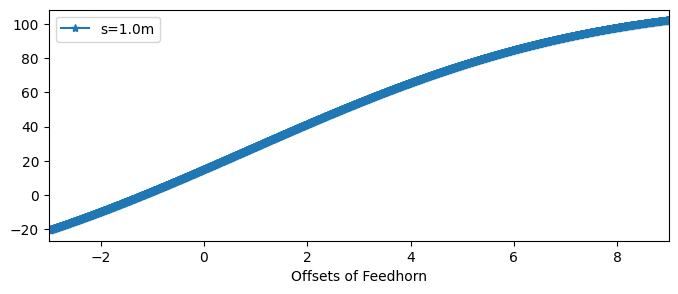

In [6]:
fig=plt.figure(figsize=(8,3))
'''Beam power in detector'''
D_z,W_z,Ws_z,Ps=p_w(win2,din2,z,1000)
print(D_z,D_z.size)
'''Beam power in detector'''
plt.plot(z,D_z,marker='*',label='s='+str(1000/1000)+'m')
#plt.ylim([0.8,1.01])
plt.xlim([z.min(),z.max()])
plt.legend()
plt.xlabel('Offsets of Feedhorn')
plt.show()

**3. Effect of uncertainty of the beamwaist size of Rx horn**

In the practical measurement, the uncertainty of the feedhorn beamwaist size will also affect the measurement results and the desired output beam waist and its position. Here, we simulate the influence of the beamwaist uncertianty for our beam measurement system.

In [7]:
Win_2=np.linspace(2.2,3.3,5)
print(Win_2)
Win_2=[2.2, 2.475, 2.74925, 3.025, 3.3]

[2.2   2.475 2.75  3.025 3.3  ]


input Beam waist2.2m [2.3136]
input Beam waist2.475m [2.34]
input Beam waist2.74925m [2.3784]
input Beam waist3.025m [2.4288]
input Beam waist3.3m [2.496]


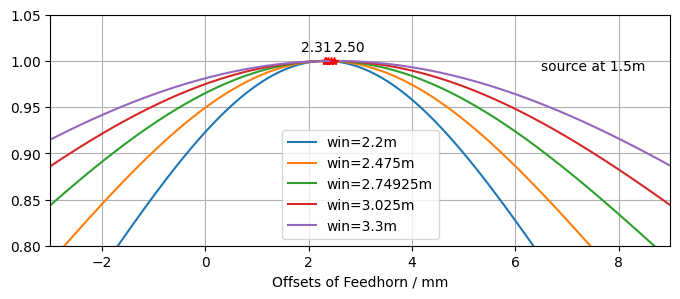

In [8]:
Distance=1500
fig=plt.figure(figsize=(8,3))
n=0
'''Beam power in detector'''
for item in Win_2:
    D,W,Ws,Ps=p_w(item,din2,z,Distance)
    '''Beam power in detector'''
    plt.plot(z,Ps,label='win='+str(item)+'m')
    NN=np.where(Ps==1.0)
    print('input Beam waist'+str(item)+'m',z[NN])
    plt.plot(z[NN],1.0,'r*')
    if n==0:
        plt.text(z[NN]*0.8,Ps[NN]*1.01, "{:.2f}".format(z[NN][0]),fontsize=10)
    n+=1
plt.ylim([0.8,1.05])
plt.xlim([z.min(),z.max()])

plt.text(z[NN]*1,Ps[NN]*1.01, "{:.2f}".format(z[NN][0]),fontsize=10)
plt.legend()
plt.xlabel('Offsets of Feedhorn / mm')
plt.text(6.5,0.99, 'source at 1.5m')
plt.grid('both')
plt.show()

input Beam waist2.2m [1.704]
input Beam waist2.475m [1.7208]
input Beam waist2.74925m [1.7424]
input Beam waist3.025m [1.7712]
input Beam waist3.3m [1.812]


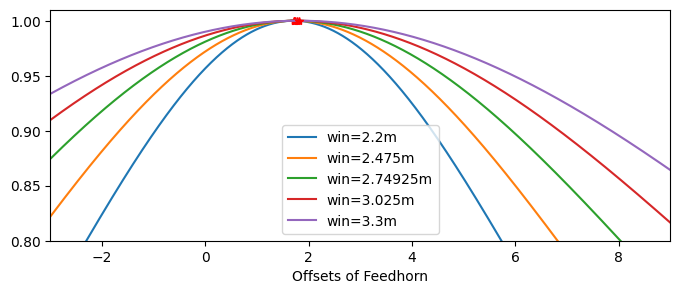

In [9]:
Distance=2500
fig=plt.figure(figsize=(8,3))

'''Beam power in detector'''
for item in Win_2:
    D,W,Ws,Ps=p_w(item,din2,z,Distance)
    '''Beam power in detector'''
    plt.plot(z,Ps,label='win='+str(item)+'m')
    NN=np.where(Ps==1.0)
    print('input Beam waist'+str(item)+'m',z[NN])
    plt.plot(z[NN],1.0,'r*')
plt.ylim([0.8,1.01])
plt.xlim([z.min(),z.max()])
plt.legend()
plt.xlabel('Offsets of Feedhorn')
plt.show()

input Beam waist2.2m [1.4496]
input Beam waist2.475m [1.4592]
input Beam waist2.74925m [1.476]
input Beam waist3.025m [1.4976]
input Beam waist3.3m [1.524]


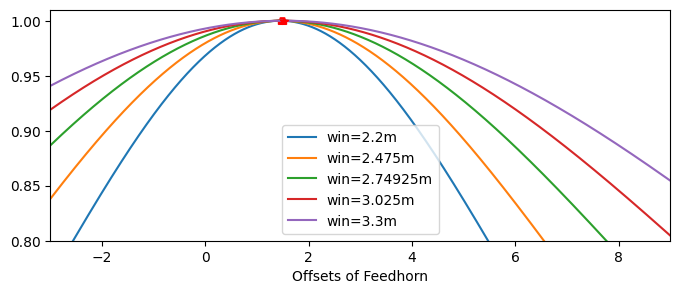

In [10]:
Distance=3500
fig=plt.figure(figsize=(8,3))

'''Beam power in detector'''
for item in Win_2:
    D,W,Ws,Ps=p_w(item,din2,z,Distance)
    '''Beam power in detector'''
    plt.plot(z,Ps,label='win='+str(item)+'m')
    NN=np.where(Ps==1.0)
    print('input Beam waist'+str(item)+'m',z[NN])
    plt.plot(z[NN],1.0,'r*')
plt.ylim([0.8,1.01])
plt.xlim([z.min(),z.max()])
plt.legend()
plt.xlabel('Offsets of Feedhorn')
plt.show()

input Beam waist2.2m [0.8256]
input Beam waist2.475m [0.8256]
input Beam waist2.74925m [0.8256]
input Beam waist3.025m [0.8256]
input Beam waist3.3m [0.8256]


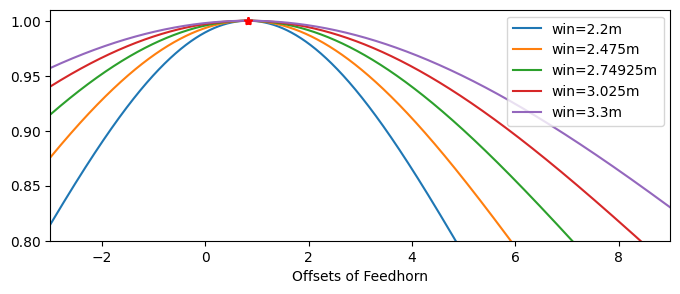

In [11]:
Distance=1000000
fig=plt.figure(figsize=(8,3))

'''Beam power in detector'''
for item in Win_2:
    D,W,Ws,Ps=p_w(item,din2,z,Distance)
    '''Beam power in detector'''
    plt.plot(z,Ps,label='win='+str(item)+'m')
    NN=np.where(Ps==1.0)
    print('input Beam waist'+str(item)+'m',z[NN])
    plt.plot(z[NN],1.0,'r*')
plt.ylim([0.8,1.01])
plt.xlim([z.min(),z.max()])
plt.legend()
plt.xlabel('Offsets of Feedhorn')
plt.show()

In [16]:
ref=np.array([8.4,7.4,7,6.7])
test=np.array([5.99,5.0,4.55,4.35])
dz=test-ref
diff=dz.mean()
print(dz,diff)


[-2.41 -2.4  -2.45 -2.35] -2.4025000000000003


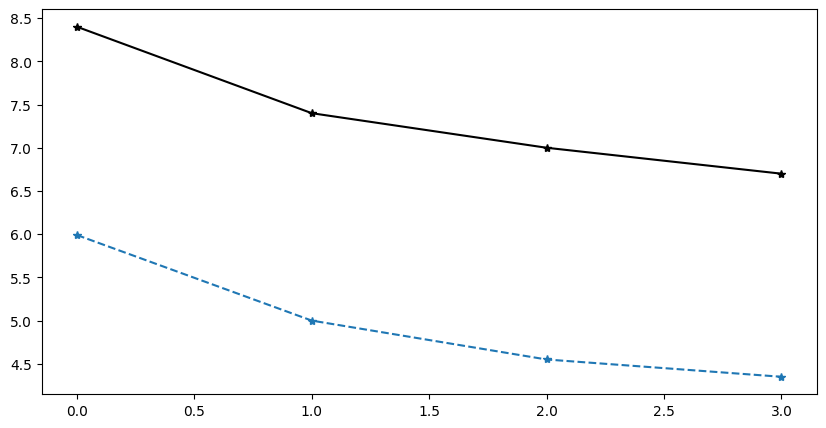

In [13]:
fig = plt.figure(figsize=(10,5))
plt.plot(test,'*--',label='test')
plt.plot(ref,'k*-',label='Ref')

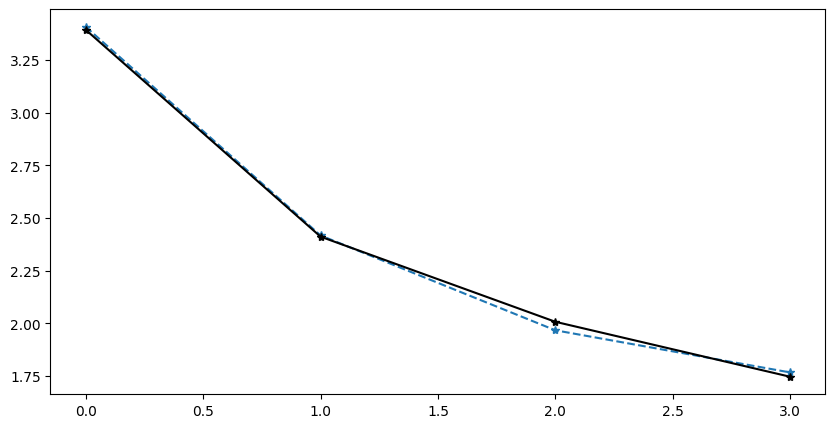

In [8]:
fig = plt.figure(figsize=(10,5))
plt.plot(test-diff,'*--',label='test')
plt.plot(ref,'k*-',label='Ref')

In [15]:
diff

2.5823